In [1]:
# # colab
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/light beam')

In [2]:
import math
import pydicom
import numpy as np 
from scipy import ndimage
import matplotlib.pyplot as plt

In [3]:
# dicom_file_path = 'images\DICOMOBJ\'
dicom_file_path = 'images/DICOMOBJ/9x7-L'
is_rotate = False

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)
arr = dicom_data.pixel_array
if is_rotate :
    arr = ndimage.rotate(arr, 90)
h, w = arr.shape
h, w

(2208, 2688)

In [4]:
def display(arr, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.axis(axis)

In [5]:
def inv_lut(arr) :
    max_p = arr.max()
    min_p = arr.min()
    return max_p - arr + min_p

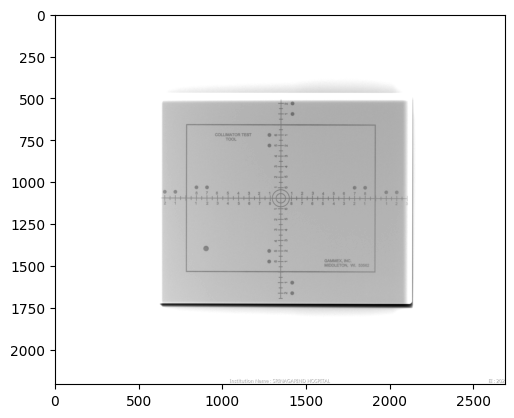

In [6]:
display(arr, True)

### Find light-beam bar

In [7]:
# assume crop if each size > 2,000 (not crop yet)
h, w = arr.shape
p = 0.24 # experimental number
if (h*w) > (2000**2) :
    arr = arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))]
    h, w = arr.shape

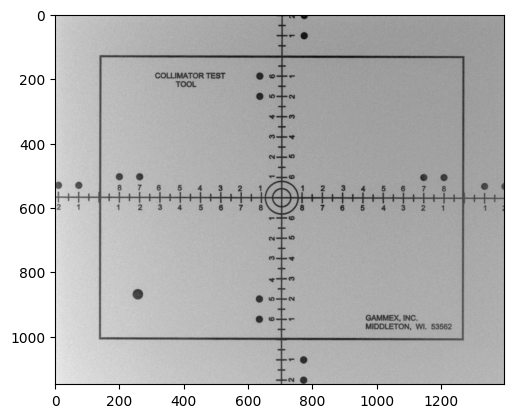

In [8]:
display(arr, True)

### Find details in full field image
- Centerline and angle for rotating the image to the axis.
- Center point.
- Rectangular field.
- Ratio to convert the number of pixels to centimeters.

In [9]:
def find_common_value(focus_arr, axis=0) :
    """
    find common value of each row or colume
    agrs: axis=0 - col, axis=1 - row
    return: most common pixel value
    """
    vals = np.argmin(focus_arr, axis=axis) #[b, w] color
    unique_elements, counts = np.unique(vals, return_counts=True)
    most_common_index = np.argmax(counts)
    val = unique_elements[most_common_index]
    return val

In [10]:
hp = int(0.15*h) # crop ratio
wp = int(0.05*w)

#left point
focus_l = arr[hp: h-hp, wp: wp*2]
vals = np.argmin(focus_l, axis=0) #[b, w] color
unique_elements, counts = np.unique(vals, return_counts=True)
most_common_index = np.argmax(counts)
val = unique_elements[most_common_index]
val, counts

(397,
 array([ 1,  2,  3,  2,  1,  3,  1,  1,  1,  1,  1,  1, 22, 27,  2],
       dtype=int64))

In [11]:
vals

array([358, 358, 352, 353, 351, 364, 353, 353, 352, 354, 354, 362, 356,
       359, 358, 397, 397, 396, 396, 396, 396, 396, 397, 396, 396, 396,
       397, 397, 397, 396, 396, 397, 396, 396, 397, 389, 403, 390, 397,
       396, 396, 397, 397, 397, 397, 396, 397, 396, 396, 396, 396, 396,
       396, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397,
       397, 396, 391, 403], dtype=int64)

In [12]:
unique_elements, counts

(array([351, 352, 353, 354, 356, 358, 359, 362, 364, 389, 390, 391, 396,
        397, 403], dtype=int64),
 array([ 1,  2,  3,  2,  1,  3,  1,  1,  1,  1,  1,  1, 22, 27,  2],
       dtype=int64))

In [13]:
def find_center_line(arr: np.array, visualize=True) :
    """
    find horizontal center line
    Return: (x1, y1), (x2, y2)
    """
    h, w = arr.shape
    hp = int(0.15*h) # crop ratio
    wp = int(0.05*w)

    #left point
    focus_l = arr[hp: h-hp, wp: wp*2]
    y1 = find_common_value(focus_l, axis=0) + hp # because focus start at hp not 0

    #Right point
    focus_r = arr[hp: h-hp, w-(wp*2): w-wp]
    y2 = find_common_value(focus_r, axis=0) + hp 

    if visualize :
        plt.figure(figsize=(3, 6))
        plt.subplot(1, 2, 1)
        display(focus_l, axis=True)
        plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

        plt.subplot(1, 2, 2)
        display(focus_r, axis=True)
        plt.tick_params(bottom=False, labelbottom=False)
        plt.suptitle(f"Center line is on \n{y1-hp} and {y2-hp} [y-axis]") # re-axis same as croped

    return (0, y1), (w, y2)

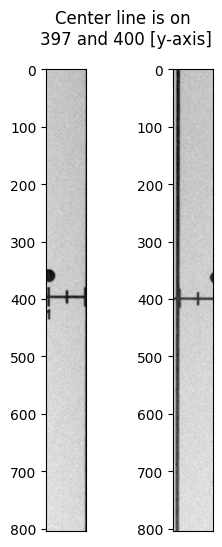

In [14]:
(x1, y1), (x2, y2) = find_center_line(arr)

In [15]:
(x1, y1), (x2, y2)

((0, 569), (1397, 572))

In [16]:
def draw_line(arr, x1, y1, x2, y2, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.plot([x1, x2], [y1, y2], color='blue', linewidth=1)
    plt.axis(axis)

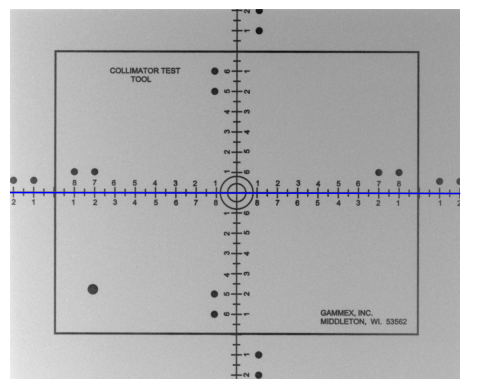

In [17]:
draw_line(arr, x1, y1, x2, y2)

In [18]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.atan(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [19]:
theta_d = find_theta(w, y1, y2)
theta_d

0.12304013909515928

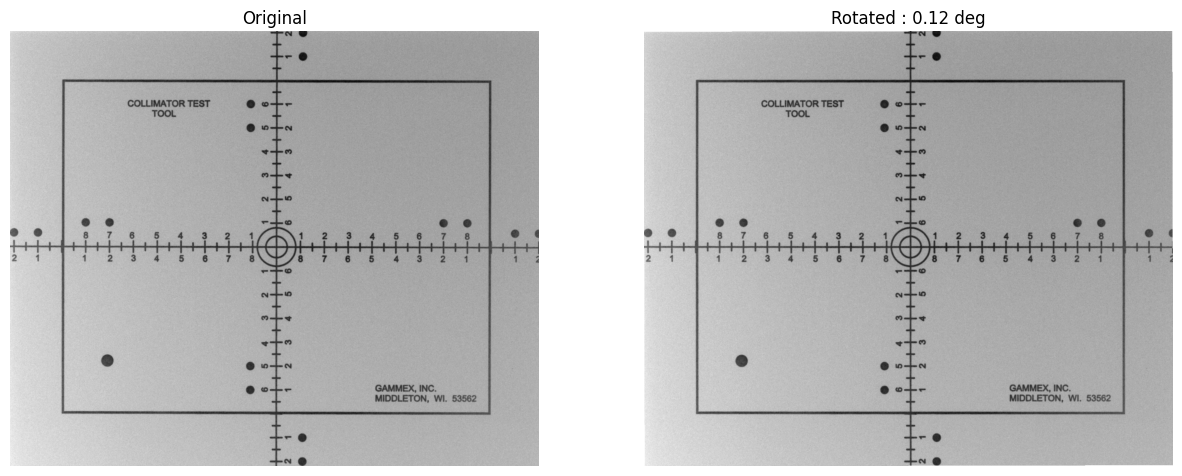

In [20]:
# CCW rotate
rotate_img = ndimage.rotate(arr, theta_d, reshape=False, cval=arr.max())
h, w = rotate_img.shape

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta_d:.2f} deg")
display(rotate_img)

In [21]:
#find horizontal lines[y-axis]
def find_horizontal_line(arr: np.array):
    """
    Return: (top(y1, y2), center(y1, y2), bottom(y1, y2))
    """
    ypoints = []
    h, w = arr.shape
    hp = int(0.27*h) # crop ratio
    wp = int(0.07*w)

    # top line
    focus_l = arr[: hp, wp*2: wp*3]
    y1 = find_common_value(focus_l, axis=0)
    focus_r = arr[: hp, w-(wp*3): w-(wp*2)]
    y2 = find_common_value(focus_l, axis=0)
    ypoints.append((y1, y2))

    #center line
    (_, y1), (_, y2) = find_center_line(arr, visualize=False)
    ypoints.append((y1, y2))

    # bottom line
    focus_l = arr[h-hp: , wp*2: wp*3]
    y1 = find_common_value(focus_l, axis=0) + h-hp
    focus_r = arr[h-hp: , w-(wp*3): w-(wp*2)]
    y2 = find_common_value(focus_r, axis=0) + h-hp
    ypoints.append((y1, y2))

    return ypoints, focus_r

In [22]:
ypoints, r = find_horizontal_line(rotate_img)
ypoints

[(132, 132), (570, 570), (1007, 1009)]

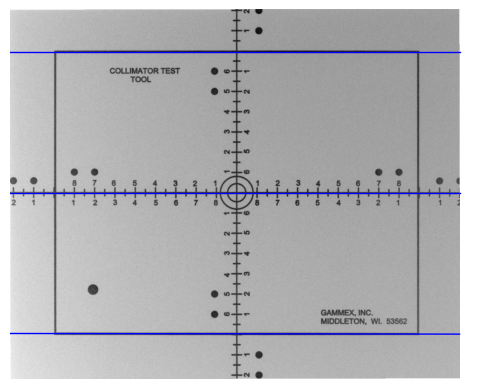

In [23]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, 0, ypoints[idx][0], w, ypoints[idx][1])

In [24]:
#find vertical lines[x-axis]
def find_vertical_line(arr: np.array):
    """
    Return: (top(x1, x2), center(x1, x2), bottom(x1, x2))
    """
    xpoints = []
    h, w = arr.shape
    hp = int(0.05*h) # crop ratio
    wp = int(0.04*w)

    # left line
    focus_t = arr[hp*3: hp*7, wp: wp*6]
    x1 = find_common_value(focus_t, axis=1) + wp
    focus_b = arr[h-hp*7: h-hp*3, wp: wp*6]
    x2 = find_common_value(focus_b, axis=1) + wp
    xpoints.append((x1, x2))

    # right line
    focus_t = arr[hp*3: hp*7, w-(wp*6): w-wp]
    x1 = find_common_value(focus_t, axis=1) + w-(wp*6)
    focus_b = arr[h-hp*7: h-hp*3, w-(wp*6): w-wp]
    x2 = find_common_value(focus_b, axis=1) + w-(wp*6)
    xpoints.append((x1, x2))

    #center line
    hp = int(0.18*h)
    wp = int(0.2*w)

    focus_t = arr[hp: hp*2, wp*2: wp*3]
    x1 = find_common_value(focus_t, axis=1) + (wp*2)
    focus_b = arr[h-(hp*2): h-hp, wp*2: wp*3]
    x2 = find_common_value(focus_b, axis=1) + (wp*2)
    xpoints.append((x1, x2))

    # swap bottom and center in xpoints
    centerpoints = xpoints[-1]
    xpoints[-1] = xpoints[1]
    xpoints[1] = centerpoints
    return xpoints

In [25]:
xpoints = find_vertical_line(rotate_img)
xpoints

[(140, 141), (703, 703), (1266, 1266)]

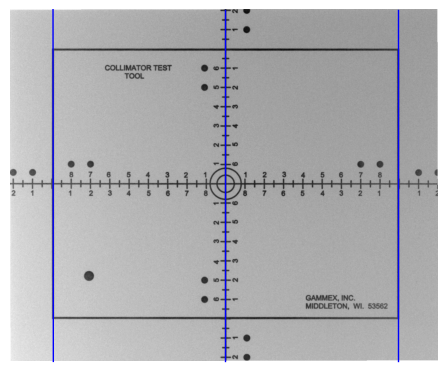

In [26]:
for idx in range(len(xpoints)) : 
    draw_line(rotate_img, xpoints[idx][0], 0, xpoints[idx][1], h)

In [27]:
xpoints = [round(np.mean(xpoints[idx])) for idx in range(3)]
ypoints = [round(np.mean(ypoints[idx])) for idx in range(3)]
xpoints, ypoints

([140, 703, 1266], [132, 570, 1008])

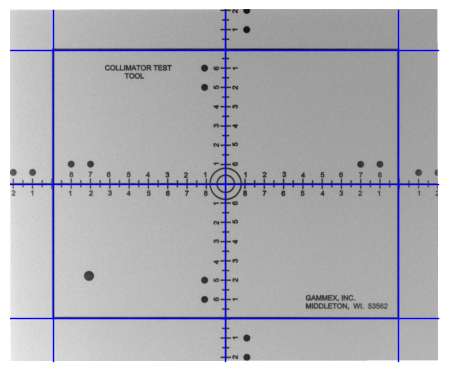

In [28]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h)
    draw_line(rotate_img, 0, ypoints[idx], w, ypoints[idx])

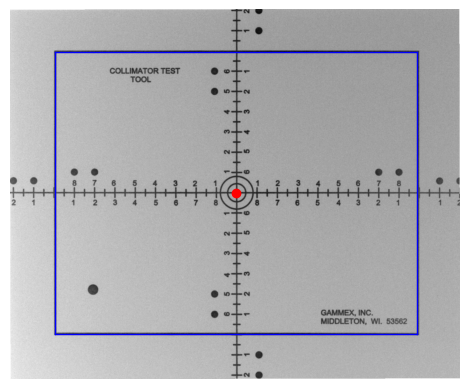

In [29]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")

In [30]:
print(f"9cm [horizontal] equal: {xpoints[2] - xpoints[1]} pixels")
print(f"7cm [vertical] equal: {ypoints[2] - ypoints[1]} pixels")

9cm [horizontal] equal: 563 pixels
7cm [vertical] equal: 438 pixels


In [31]:
def pixel2cm(number_pixel: int, is_rotate) :
    """
    convert number of pixel to centimeter as aspect ratio
    """
    _cm = ypoints[2] - ypoints[1]
    ratio = 7
    if is_rotate :
        ratio = 9
    return round(number_pixel*ratio/_cm, 2)

In [32]:
pixel2cm(438, is_rotate)

7.0

### 9x7cm

In [33]:
dicom_file_path = 'images/DICOMOBJ/9x7'

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)
arr = dicom_data.pixel_array
if is_rotate :
    arr = ndimage.rotate(arr, 90)

h, w = arr.shape

# assume crop if each size > 2,000 (not crop yet)
p = 0.24 # experimental number
if (h*w) > (2000**2) :
    arr = arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))]
    h, w = arr.shape

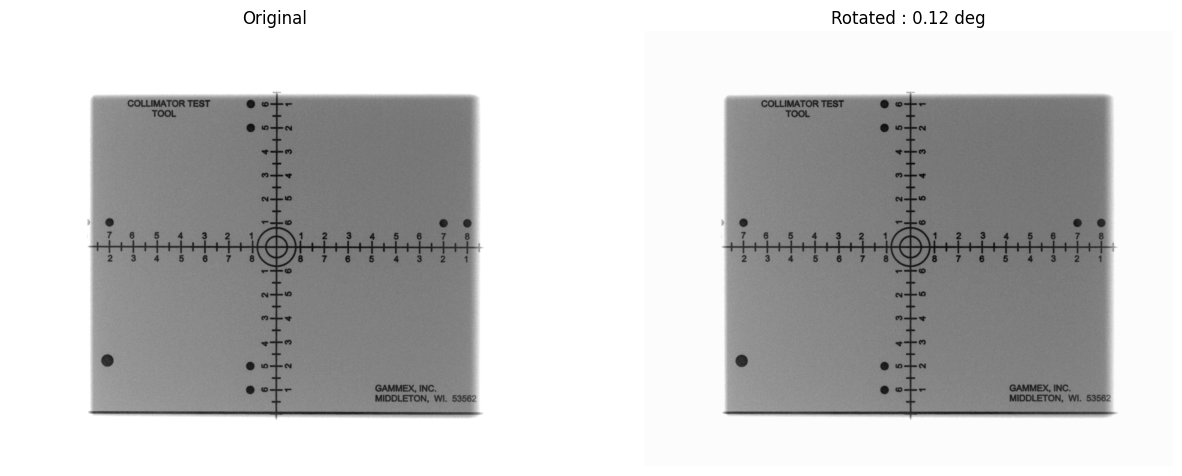

In [34]:
rotate_img = ndimage.rotate(arr, theta_d, reshape=False, cval=arr.max())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta_d:.2f} deg")
display(rotate_img)

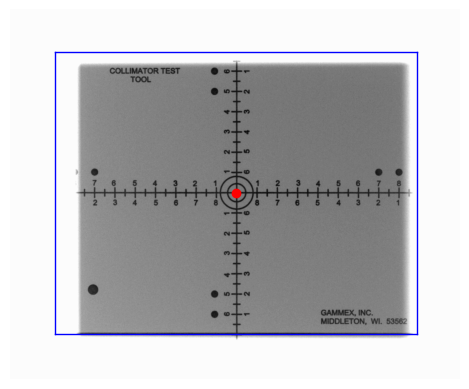

In [35]:
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")

### Find difference between bouding box and actual area

In [36]:
xpoints, ypoints

([140, 703, 1266], [132, 570, 1008])

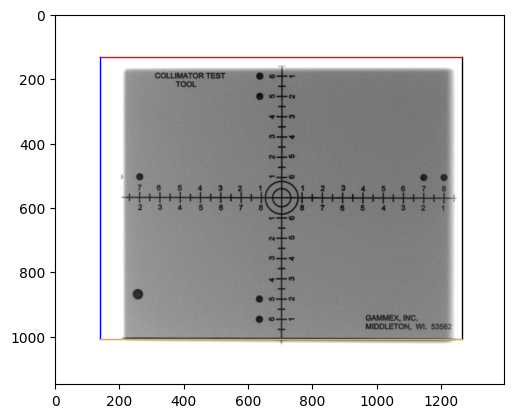

In [37]:
plt.imshow(arr, cmap="gray")
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
plt.plot([xpoints[2], xpoints[2]], [ypoints[0], ypoints[2]], color='k', linewidth=1)
plt.plot([xpoints[0], xpoints[2]], [ypoints[0], ypoints[0]], color='red', linewidth=1)
plt.plot([xpoints[0], xpoints[2]], [ypoints[2], ypoints[2]], color='orange', linewidth=1)

In [38]:
# find y1 distance[left]
center_p = xpoints[1], ypoints[1]
left_point = xpoints[0], ypoints[1]
center_p, left_point

((703, 570), (140, 570))

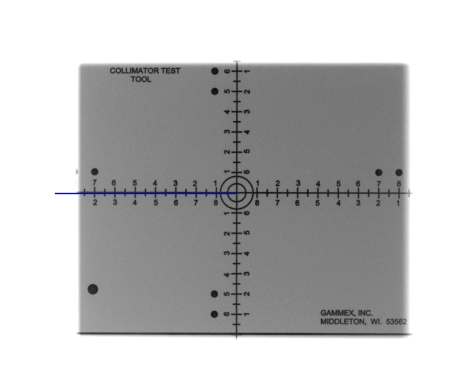

In [39]:
draw_line(arr, center_p[0], center_p[1], left_point[0], left_point[1])

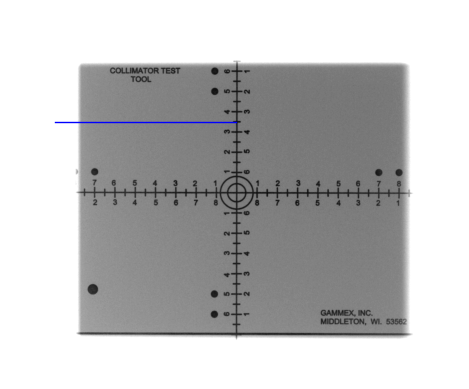

In [40]:
# estimate line between top and center: to escepe center black line
center_p = xpoints[1], (ypoints[0] + ypoints[1])//2
left_p = xpoints[0], (ypoints[0]+ypoints[1])//2
draw_line(arr, center_p[0], center_p[1], left_p[0], left_p[1])

In [41]:
crop_ratio = 0.2
add_horizontal_crop = int((left_p[0]*(1-crop_ratio)) + (center_p[0]*crop_ratio)) - left_p[0]
add_vertical_crop = int(h*0.04)
add_horizontal_crop, add_vertical_crop

(112, 45)

In [42]:
top_left_point = max(left_p[0]-add_horizontal_crop, 0), max(left_p[1]-add_vertical_crop, 0) # prevent negative 
bottom_right_point = left_p[0]+add_horizontal_crop, left_p[1]+add_vertical_crop
top_left_point, bottom_right_point

((28, 306), (252, 396))

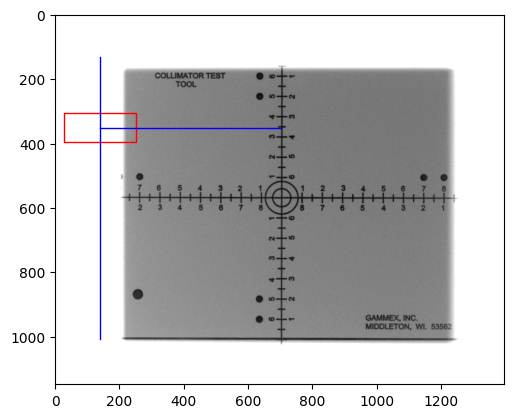

In [43]:
# crop left area
from matplotlib.patches import Rectangle

ax = plt.gca()
display(arr, True)
(x, y), w, h = top_left_point, bottom_right_point[0]-top_left_point[0], bottom_right_point[1]-top_left_point[1]
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
plt.plot([center_p[0], left_p[0]], [center_p[1], left_p[1]], color='blue', linewidth=1)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)

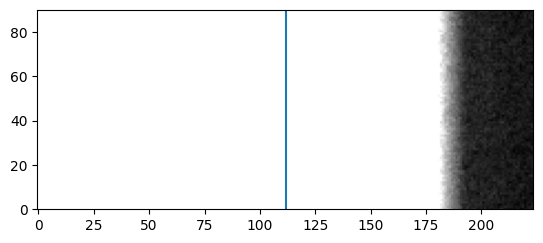

In [44]:
left_focus = arr[top_left_point[1]: bottom_right_point[1], top_left_point[0]: bottom_right_point[0]]
display(left_focus, True)
plt.plot([xpoints[0]-top_left_point[0], xpoints[0]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);

In [45]:
def argdiffs(arr, by_col=True) :
    """ 
    find most difference value by coloumn or row
    
    Return :
        most difference idx
    """
    nrows, ncols = arr.shape
    max_diffs = []
    if by_col :
        for r in range(nrows) :
            max_diff = 0
            max_diff_idx = 0
            for c in range(ncols-1) :
                cur_val = arr[r][c]
                next_val = arr[r][c+1]
                diff = abs(int(cur_val)-int(next_val))
                if diff > max_diff :
                    max_diff = diff 
                    max_diff_idx = c
            max_diffs.append(max_diff_idx)
    else :
        for c in range(ncols) :
            max_diff = 0
            max_diff_idx = 0
            for r in range(nrows-1) :
                cur_val = arr[r][c]
                next_val = arr[r+1][c]
                diff = abs(int(cur_val)-int(next_val))
                if diff > max_diff :
                    max_diff = diff 
                    max_diff_idx = c
            max_diffs.append(max_diff_idx)

    unique_elements, counts = np.unique(max_diffs, return_counts=True)
    most_common_index = np.argmax(counts)
    val = unique_elements[most_common_index]
    return val

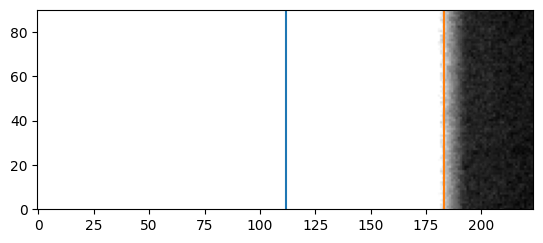

In [46]:
diff_col = argdiffs(left_focus, True)
display(left_focus, True)
plt.plot([xpoints[0]-top_left_point[0], xpoints[0]-top_left_point[0]], [0, bottom_right_point[1]-top_left_point[1]])
plt.plot([diff_col, diff_col], [0, bottom_right_point[1]-top_left_point[1]])
plt.ylim([0, bottom_right_point[1]-top_left_point[1]]);

In [47]:
xpoints[0]-top_left_point[0], diff_col

(112, 183)

In [48]:
length_diff = pixel2cm((xpoints[0]-top_left_point[0]) - diff_col, is_rotate)
length_diff

-1.13

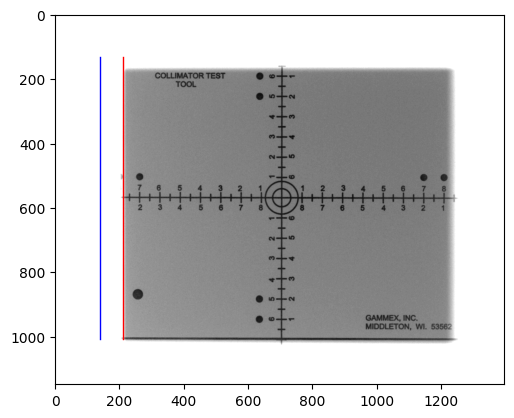

In [49]:
display(arr, True)
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='blue', linewidth=1)
diff_col = diff_col + top_left_point[0] # to reset position same as large arr
plt.plot([diff_col, diff_col], [ypoints[0], ypoints[2]], color='red', linewidth=1)

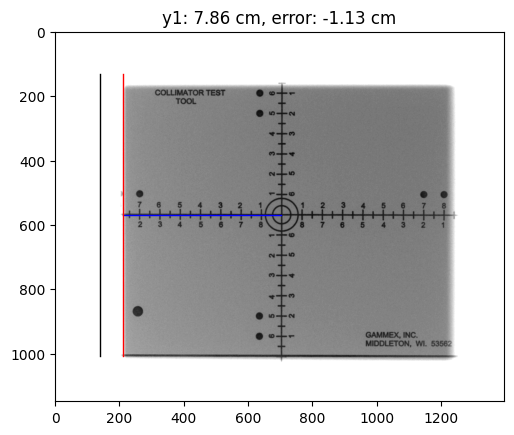

In [50]:
draw_line(arr, diff_col, ypoints[1], xpoints[1], ypoints[1], True)
plt.plot([diff_col, diff_col], [ypoints[0], ypoints[2]], color='red', linewidth=1)
plt.plot([xpoints[0], xpoints[0]], [ypoints[0], ypoints[2]], color='k', linewidth=1)
length_y1 = pixel2cm(xpoints[1] - diff_col, is_rotate)
plt.title(f"y1: {length_y1:.2f} cm, error: {length_diff:.2f} cm");